# Comparing the different GMAC models with other models 

### Getting the data

If you do not already have the data to run this this notebook, you need to
download it from here.



### Standards modules

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import scipy
from scipy import signal
import pathlib
import itertools
import glob

In [3]:
import seaborn as sns
from matplotlib import gridspec

### Custom Modules

In [4]:
sys.path.append("../scripts")

import classification_algorithms as ca
import reduced_models as rm
import task_analysis as ta

import misc

In [5]:
import gmac

In [6]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica']
plt.rcParams['font.weight'] = 'light'

## Define notebook level constants

In [7]:
# Sampling rate for the data is 50ms
dT = 0.02
Fs = int(1 / dT)

## Read the Controls and Patients Data

In [8]:
# Read healthy and control data
left, right = misc.read_data(subject_type='control')
aff, unaff = misc.read_data(subject_type='patient')

# Assign segments for each subject
left = pd.concat([misc.assign_segments(left[left.subject == subj], dur_th=1, dT=dT)
                  for subj in left.subject.unique()], axis=0)
right = pd.concat([misc.assign_segments(right[right.subject == subj], dur_th=1, dT=dT)
                   for subj in right.subject.unique()])
aff = pd.concat([misc.assign_segments(aff[aff.subject == subj], dur_th=1, dT=dT)
                 for subj in aff.subject.unique()])
unaff = pd.concat([misc.assign_segments(unaff[unaff.subject == subj], dur_th=1, dT=dT)
                   for subj in unaff.subject.unique()])

# All limbs data ddf
datadf = {
    "left": left,
    "right": right,
    "aff": aff,
    "unaff": unaff
}

#### Parameter ranges for the grid search

In [9]:
basedir = "../data/output-new/"
outdir = pathlib.Path(basedir, "gmac2", "comparisons")
outdir.mkdir(parents=True, exist_ok=True)

# GMAC Parameter ranges
gmac_param_ranges = {
    "np": [int(Fs // 2)],
    "fc": [0.1],
    "nc": [2],
    "nam": [int(5*Fs)],
    "p_th": np.arange(-90, 90, 10),
    "p_th_band": np.arange(0, 80, 20),
    "am_th": [-1, 0, 0.01, 0.05, 0.1, 0.25, 0.5, 1.0],
    "am_th_band": [0, 0.01, 0.05, 0.1]
}

### Read the data from the differnet parameter combinations

In [10]:
# Read and combine data from different subjects in one file.
gmac_perf_df = {
    _lmb: pd.read_csv(pathlib.Path(basedir, _lmb, "gmac2", "gmac2.csv").as_posix())
    for _lmb in ["left", "right", "aff", "unaff"]
}

In [11]:
# Read data from Tanya's paper
tempdf = pd.read_csv("../data/subash22data.csv")
del tempdf["Unnamed: 0"]

# Organize data into dictionary
limbsdef = {
    "left": "left",
    "right": "right",
    "aff": "affected",
    "unaff": "unaffected"
}
subash22df = {
    lk: tempdf[tempdf.hand == lv].reset_index(drop=True)
    for lk, lv in limbsdef.items()
}

### Comparison: Three parameter combinations with old GMAC and RF-inter subject Models

In [37]:
pc_combs = [
    [0.1, 10, 40],
    [0.1, 10, 60],
    [0.1, 20, 40],
    [0.1, 20, 60],
]

# Limbs
limbs = ["left", "right", "aff", "unaff"]
curr_perf = {
    "youden": [[] for _ in limbs],
    "sensitivity": [[] for _ in limbs],
    "specificity": [[] for _ in limbs],
}
for i, limb in enumerate(limbs):
    for j in range(len(pc_combs)):
        _inx = ((gmac_perf_df[limb]["am_th"] == pc_combs[j][0]) &
                (gmac_perf_df[limb]["am_th_band"] == 0) &
                (gmac_perf_df[limb]["p_th"] == pc_combs[j][1]) &
                (gmac_perf_df[limb]["p_th_band"] == pc_combs[j][2]))
        curr_perf["youden"][i].append(gmac_perf_df[limb][_inx]["youden"].values)
        curr_perf["sensitivity"][i].append(gmac_perf_df[limb][_inx]["sensitivity"].values)
        curr_perf["specificity"][i].append(gmac_perf_df[limb][_inx]["specificity"].values)

In [38]:
# Limbs
limbs = ["left", "right", "aff", "unaff"]
prev_perf_gmac = {
    "youden": [],
    "sensitivity": [],
    "specificity": [],
}

model = "GMAC"
for i, limb in enumerate(limbs):
    _inx = (subash22df[limb].method == model)
    prev_perf_gmac["youden"].append(subash22df[limb][_inx]["youden"].values)
    prev_perf_gmac["sensitivity"].append(subash22df[limb][_inx]["sensitivity"].values)
    prev_perf_gmac["specificity"].append(subash22df[limb][_inx]["specificity"].values)

# RF Intersubject
prev_perf_rfinter = {
    "youden": [],
    "sensitivity": [],
    "specificity": [],
}

model = "RF inter"
for i, limb in enumerate(limbs):
    _inx = (subash22df[limb].method == model)
    prev_perf_rfinter["youden"].append(subash22df[limb][_inx]["youden"].values)
    prev_perf_rfinter["sensitivity"].append(subash22df[limb][_inx]["sensitivity"].values)
    prev_perf_rfinter["specificity"].append(subash22df[limb][_inx]["specificity"].values)

# RF Intrasubject
prev_perf_rfintra = {
    "youden": [],
    "sensitivity": [],
    "specificity": [],
}

model = "RF intra"
for i, limb in enumerate(limbs):
    _inx = (subash22df[limb].method == model)
    prev_perf_rfintra["youden"].append(subash22df[limb][_inx]["youden"].values)
    prev_perf_rfintra["sensitivity"].append(subash22df[limb][_inx]["sensitivity"].values)
    prev_perf_rfintra["specificity"].append(subash22df[limb][_inx]["specificity"].values)

# RF Intrasubject mean
prev_perf_rfintra_mean = {
    "youden": [],
    "sensitivity": [],
    "specificity": [],
}

model = "RF intra"
for i, limb in enumerate(limbs):
    _inx = (subash22df[limb].method == model)
    prev_perf_rfintra_mean["youden"].append(subash22df[limb][_inx].groupby("subject")["youden"].mean().values)
    prev_perf_rfintra_mean["sensitivity"].append(subash22df[limb][_inx].groupby("subject")["youden"].mean().values)
    prev_perf_rfintra_mean["specificity"].append(subash22df[limb][_inx].groupby("subject")["youden"].mean().values)

IndexError: list index out of range

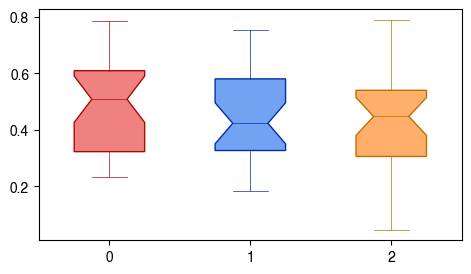

In [40]:
# Combine data from all limbs
lightc = ["#f08181", "#72a3f2", "#ffaf69", "#ababab", "#d2a679", "#b2b266", "#b2b266"]
darkc = ["#a80a0a", "#002eab", "#bd6e00", "black", "#86592d", "#55552b", "#55552b"]
fig = plt.figure(figsize=(9, 3))
gs = gridspec.GridSpec(1, 2, height_ratios=[1], width_ratios=[2, 1])
ax = plt.subplot(gs[0, 0])

# Current performance
for j in range(4):
    _vals = np.hstack([curr_perf["youden"][i][j] for i in range(4)])

    ax.boxplot(x=_vals, positions=[j],
            widths=0.5, notch=True, patch_artist=True,
            boxprops=dict(facecolor=lightc[j], color=darkc[j], alpha=1.0),
            capprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
            whiskerprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
            flierprops=dict(color=darkc[j], markeredgecolor=darkc[j],
                            markerfacecolor=darkc[j], marker='+', markersize=4),
            medianprops=dict(color=darkc[j], alpha=1.0, lw=0.5))

# Previous performance
# GMAC
j = 1 + 3
_vals = np.hstack([prev_perf_gmac["youden"][i] for i in range(4)])
ax.boxplot(x=_vals, positions=[j],
           widths=0.5, notch=True, patch_artist=True,
           boxprops=dict(facecolor=lightc[j], color=darkc[j], alpha=1.0),
           capprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
           whiskerprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
           flierprops=dict(color=darkc[j], markeredgecolor=darkc[j],
                           markerfacecolor=darkc[j], marker='+', markersize=4),
           medianprops=dict(color=darkc[j], alpha=1.0, lw=0.5))
# RF INTER
j = 1 + 4
_vals = np.hstack([prev_perf_rfinter["youden"][i] for i in range(4)])
ax.boxplot(x=_vals, positions=[j],
           widths=0.5, notch=True, patch_artist=True,
           boxprops=dict(facecolor=lightc[j], color=darkc[j], alpha=1.0),
           capprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
           whiskerprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
           flierprops=dict(color=darkc[j], markeredgecolor=darkc[j],
                           markerfacecolor=darkc[j], marker='+', markersize=4),
           medianprops=dict(color=darkc[j], alpha=1.0, lw=0.5))
# RF INTRA
j = 1 + 5
_vals = np.hstack([prev_perf_rfintra["youden"][i] for i in range(4)])
_vals = _vals[~np.isnan(_vals)]
ax.boxplot(x=_vals, positions=[j],
           widths=0.5, notch=True, patch_artist=True,
           boxprops=dict(facecolor=lightc[j], color=darkc[j], alpha=1.0),
           capprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
           whiskerprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
           flierprops=dict(color=darkc[j], markeredgecolor=darkc[j],
                           markerfacecolor=darkc[j], marker='+', markersize=4),
           medianprops=dict(color=darkc[j], alpha=1.0, lw=0.5))
# Backgrounds
background = plt.Rectangle((0.5, 0), 1, 1,
                           transform=ax.transAxes,
                           color='#fff5cc', zorder=-1)
ax.add_patch(background)
ax.text(0.75, 0.95, "Subash et al. 2022", ha="center", va="center", fontsize=12,
        color="#665200", transform=ax.transAxes,)

ax.set_ylim(0.0, 1.0)
ax.set_xlim(-0.5, 5.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
ax.grid(color='0.8', linestyle='--', linewidth=0.5);
ax.set_xticklabels(
    [f"Comb. {i+1}" for i in range(4)] +
    ["Old GMAC", "RF Inter", "RF Intra"],
)
ax.set_ylabel("Youden Index", fontsize=12)
ax.set_title("Younden Index comparison", fontsize=13)

# # ROC plot
# ax = plt.subplot(gs[0, 1])
# ax.plot([0, 1], [0, 1], lw=1, color="black", ls="--")
# # PC 3
# _valsens = np.hstack([curr_perf["sensitivity"][i][2] for i in range(4)])
# _valspec = np.hstack([curr_perf["specificity"][i][2] for i in range(4)])
# _xmean, _ymean = np.mean(_valspec), np.mean(_valsens)
# _xstd, _ystd = np.std(_valspec), np.std(_valsens)
# ax.plot([1 - _xmean - 0.5 * _xstd, 1 - _xmean + 0.5 * _xstd],
#         [_ymean, _ymean], color=darkc[2], alpha=0.3, lw=1)
# ax.plot([1 - _xmean, 1 - _xmean],
#         [_ymean - 0.5 * _ystd, _ymean + 0.5 * _ystd], color=darkc[2], alpha=0.3, lw=1)
# ax.plot([1 - _xmean], [_ymean], marker="s", ms=6, color=lightc[2], alpha=1)
# # PC 1
# _valsens = np.hstack([curr_perf["sensitivity"][i][0] for i in range(4)])
# _valspec = np.hstack([curr_perf["specificity"][i][0] for i in range(4)])
# _xmean, _ymean = np.mean(_valspec), np.mean(_valsens)
# _xstd, _ystd = np.std(_valspec), np.std(_valsens)
# ax.plot([1 - _xmean - 0.5 * _xstd, 1 - _xmean + 0.5 * _xstd],
#         [_ymean, _ymean], color=darkc[0], alpha=0.3, lw=1)
# ax.plot([1 - _xmean, 1 - _xmean],
#         [_ymean - 0.5 * _ystd, _ymean + 0.5 * _ystd], color=darkc[0], alpha=0.3, lw=1)
# ax.plot([1 - _xmean], [_ymean], marker="s", ms=6, color=lightc[0], alpha=1)

# # Old GMAC
# _valsens = np.hstack([prev_perf_gmac["sensitivity"][i] for i in range(4)])
# _valspec = np.hstack([prev_perf_gmac["specificity"][i] for i in range(4)])
# _xmean, _ymean = np.mean(_valspec), np.mean(_valsens)
# _xstd, _ystd = np.std(_valspec), np.std(_valsens)
# ax.plot([1 - _xmean - 0.5 * _xstd, 1 - _xmean + 0.5 * _xstd],
#         [_ymean, _ymean], color=darkc[3], alpha=0.3, lw=1)
# ax.plot([1 - _xmean, 1 - _xmean],
#         [_ymean - 0.5 * _ystd, _ymean + 0.5 * _ystd], color=darkc[3], alpha=0.3, lw=1)
# ax.plot([1 - _xmean], [_ymean], marker="o", ms=6, color=lightc[3], alpha=1)
# # RF Inter
# _valsens = np.hstack([prev_perf_rfinter["sensitivity"][i] for i in range(4)])
# _valspec = np.hstack([prev_perf_rfinter["specificity"][i] for i in range(4)])
# _xmean, _ymean = np.mean(_valspec), np.mean(_valsens)
# _xstd, _ystd = np.std(_valspec), np.std(_valsens)
# ax.plot([1 - _xmean - 0.5 * _xstd, 1 - _xmean + 0.5 * _xstd],
#         [_ymean, _ymean], color=darkc[4], alpha=0.3, lw=1)
# ax.plot([1 - _xmean, 1 - _xmean],
#         [_ymean - 0.5 * _ystd, _ymean + 0.5 * _ystd], color=darkc[4], alpha=0.3, lw=1)
# ax.plot([1 - _xmean], [_ymean], marker="o", ms=6, color=lightc[4], alpha=1)
# # RF Intra
# _valsens = np.hstack([prev_perf_rfintra["sensitivity"][i] for i in range(4)])
# _valspec = np.hstack([prev_perf_rfintra["specificity"][i] for i in range(4)])
# _xmean, _ymean = np.nanmean(_valspec), np.nanmean(_valsens)
# _xstd, _ystd = np.nanstd(_valspec), np.nanstd(_valsens)
# ax.plot([1 - _xmean - 0.5 * _xstd, 1 - _xmean + 0.5 * _xstd],
#         [_ymean, _ymean], color=darkc[5], alpha=0.3, lw=1)
# ax.plot([1 - _xmean, 1 - _xmean],
#         [_ymean - 0.5 * _ystd, _ymean + 0.5 * _ystd], color=darkc[5], alpha=0.3, lw=1)
# ax.plot([1 - _xmean], [_ymean], marker="o", ms=6, color=lightc[5], alpha=1)

# # PC 2
# _valsens = np.hstack([curr_perf["sensitivity"][i][1] for i in range(4)])
# _valspec = np.hstack([curr_perf["specificity"][i][1] for i in range(4)])
# _xmean, _ymean = np.mean(_valspec), np.mean(_valsens)
# _xstd, _ystd = np.std(_valspec), np.std(_valsens)
# ax.plot([1 - _xmean - 0.5 * _xstd, 1 - _xmean + 0.5 * _xstd],
#         [_ymean, _ymean], color=darkc[1], alpha=1, lw=1)
# ax.plot([1 - _xmean, 1 - _xmean],
#         [_ymean - 0.5 * _ystd, _ymean + 0.5 * _ystd], color=darkc[1], alpha=1, lw=1)
# ax.plot([1 - _xmean], [_ymean], marker="s", ms=6, color=lightc[1])

# ax.set_ylim(-0.01, 1.01)
# ax.set_xlim(0.0, 1.01)
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# ax.spines['left'].set_position(('outward', 5))
# ax.spines['bottom'].set_position(('outward', 5))
# ax.spines['left'].set_color("tab:gray")
# ax.spines['bottom'].set_color("tab:gray")
# ax.tick_params(axis='x', colors='0.3')
# ax.tick_params(axis='y', colors='0.3')
# ax.grid(color='0.8', linestyle='--', linewidth=0.5);
# ax.set_ylabel("Sensitivity", fontsize=12)
# ax.set_xlabel("1 - Specificity", fontsize=12)
# ax.set_title("ROC", fontsize=13)

plt.tight_layout()

fig.savefig(pathlib.Path(outdir, "gmac_summary_all.pdf"), bbox_inches="tight")
fig.savefig(pathlib.Path(outdir, "gmac_summary_all.svg"), bbox_inches="tight")

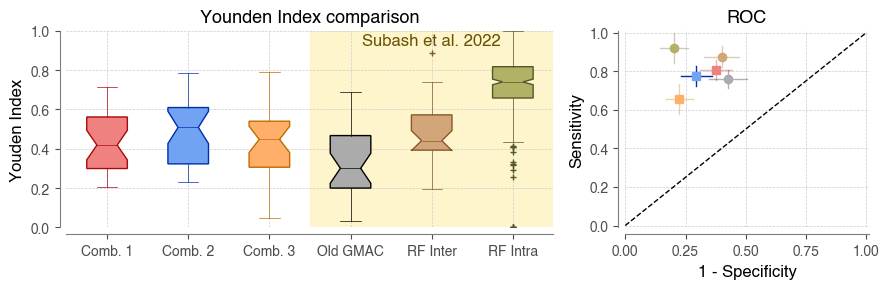

In [36]:
# Combine data from all limbs
lightc = ["#f08181", "#72a3f2", "#ffaf69", "#ababab", "#d2a679", "#b2b266"]
darkc = ["#a80a0a", "#002eab", "#bd6e00", "black", "#86592d", "#55552b"]
fig = plt.figure(figsize=(9, 3))
gs = gridspec.GridSpec(1, 2, height_ratios=[1], width_ratios=[2, 1])
ax = plt.subplot(gs[0, 0])

# Current performance
for j in range(3):
    _vals = np.hstack([curr_perf["youden"][i][j] for i in range(4)])

    ax.boxplot(x=_vals, positions=[j],
            widths=0.5, notch=True, patch_artist=True,
            boxprops=dict(facecolor=lightc[j], color=darkc[j], alpha=1.0),
            capprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
            whiskerprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
            flierprops=dict(color=darkc[j], markeredgecolor=darkc[j],
                            markerfacecolor=darkc[j], marker='+', markersize=4),
            medianprops=dict(color=darkc[j], alpha=1.0, lw=0.5))

# Previous performance
# GMAC
j = 3
_vals = np.hstack([prev_perf_gmac["youden"][i] for i in range(4)])
ax.boxplot(x=_vals, positions=[j],
           widths=0.5, notch=True, patch_artist=True,
           boxprops=dict(facecolor=lightc[j], color=darkc[j], alpha=1.0),
           capprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
           whiskerprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
           flierprops=dict(color=darkc[j], markeredgecolor=darkc[j],
                           markerfacecolor=darkc[j], marker='+', markersize=4),
           medianprops=dict(color=darkc[j], alpha=1.0, lw=0.5))
# RF INTER
j = 4
_vals = np.hstack([prev_perf_rfinter["youden"][i] for i in range(4)])
ax.boxplot(x=_vals, positions=[j],
           widths=0.5, notch=True, patch_artist=True,
           boxprops=dict(facecolor=lightc[j], color=darkc[j], alpha=1.0),
           capprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
           whiskerprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
           flierprops=dict(color=darkc[j], markeredgecolor=darkc[j],
                           markerfacecolor=darkc[j], marker='+', markersize=4),
           medianprops=dict(color=darkc[j], alpha=1.0, lw=0.5))
# RF INTRA
j = 5
_vals = np.hstack([prev_perf_rfintra["youden"][i] for i in range(4)])
_vals = _vals[~np.isnan(_vals)]
ax.boxplot(x=_vals, positions=[j],
           widths=0.5, notch=True, patch_artist=True,
           boxprops=dict(facecolor=lightc[j], color=darkc[j], alpha=1.0),
           capprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
           whiskerprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
           flierprops=dict(color=darkc[j], markeredgecolor=darkc[j],
                           markerfacecolor=darkc[j], marker='+', markersize=4),
           medianprops=dict(color=darkc[j], alpha=1.0, lw=0.5))
# Backgrounds
background = plt.Rectangle((0.5, 0), 1, 1,
                           transform=ax.transAxes,
                           color='#fff5cc', zorder=-1)
ax.add_patch(background)
ax.text(0.75, 0.95, "Subash et al. 2022", ha="center", va="center", fontsize=12,
        color="#665200", transform=ax.transAxes,)

ax.set_ylim(0.0, 1.0)
ax.set_xlim(-0.5, 5.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
ax.grid(color='0.8', linestyle='--', linewidth=0.5);
ax.set_xticklabels(
    [f"Comb. {i+1}" for i in range(3)] +
    ["Old GMAC", "RF Inter", "RF Intra"],
)
ax.set_ylabel("Youden Index", fontsize=12)
ax.set_title("Younden Index comparison", fontsize=13)

# ROC plot
ax = plt.subplot(gs[0, 1])
ax.plot([0, 1], [0, 1], lw=1, color="black", ls="--")
# PC 3
_valsens = np.hstack([curr_perf["sensitivity"][i][2] for i in range(4)])
_valspec = np.hstack([curr_perf["specificity"][i][2] for i in range(4)])
_xmean, _ymean = np.mean(_valspec), np.mean(_valsens)
_xstd, _ystd = np.std(_valspec), np.std(_valsens)
ax.plot([1 - _xmean - 0.5 * _xstd, 1 - _xmean + 0.5 * _xstd],
        [_ymean, _ymean], color=darkc[2], alpha=0.3, lw=1)
ax.plot([1 - _xmean, 1 - _xmean],
        [_ymean - 0.5 * _ystd, _ymean + 0.5 * _ystd], color=darkc[2], alpha=0.3, lw=1)
ax.plot([1 - _xmean], [_ymean], marker="s", ms=6, color=lightc[2], alpha=1)
# PC 1
_valsens = np.hstack([curr_perf["sensitivity"][i][0] for i in range(4)])
_valspec = np.hstack([curr_perf["specificity"][i][0] for i in range(4)])
_xmean, _ymean = np.mean(_valspec), np.mean(_valsens)
_xstd, _ystd = np.std(_valspec), np.std(_valsens)
ax.plot([1 - _xmean - 0.5 * _xstd, 1 - _xmean + 0.5 * _xstd],
        [_ymean, _ymean], color=darkc[0], alpha=0.3, lw=1)
ax.plot([1 - _xmean, 1 - _xmean],
        [_ymean - 0.5 * _ystd, _ymean + 0.5 * _ystd], color=darkc[0], alpha=0.3, lw=1)
ax.plot([1 - _xmean], [_ymean], marker="s", ms=6, color=lightc[0], alpha=1)

# Old GMAC
_valsens = np.hstack([prev_perf_gmac["sensitivity"][i] for i in range(4)])
_valspec = np.hstack([prev_perf_gmac["specificity"][i] for i in range(4)])
_xmean, _ymean = np.mean(_valspec), np.mean(_valsens)
_xstd, _ystd = np.std(_valspec), np.std(_valsens)
ax.plot([1 - _xmean - 0.5 * _xstd, 1 - _xmean + 0.5 * _xstd],
        [_ymean, _ymean], color=darkc[3], alpha=0.3, lw=1)
ax.plot([1 - _xmean, 1 - _xmean],
        [_ymean - 0.5 * _ystd, _ymean + 0.5 * _ystd], color=darkc[3], alpha=0.3, lw=1)
ax.plot([1 - _xmean], [_ymean], marker="o", ms=6, color=lightc[3], alpha=1)
# RF Inter
_valsens = np.hstack([prev_perf_rfinter["sensitivity"][i] for i in range(4)])
_valspec = np.hstack([prev_perf_rfinter["specificity"][i] for i in range(4)])
_xmean, _ymean = np.mean(_valspec), np.mean(_valsens)
_xstd, _ystd = np.std(_valspec), np.std(_valsens)
ax.plot([1 - _xmean - 0.5 * _xstd, 1 - _xmean + 0.5 * _xstd],
        [_ymean, _ymean], color=darkc[4], alpha=0.3, lw=1)
ax.plot([1 - _xmean, 1 - _xmean],
        [_ymean - 0.5 * _ystd, _ymean + 0.5 * _ystd], color=darkc[4], alpha=0.3, lw=1)
ax.plot([1 - _xmean], [_ymean], marker="o", ms=6, color=lightc[4], alpha=1)
# RF Intra
_valsens = np.hstack([prev_perf_rfintra["sensitivity"][i] for i in range(4)])
_valspec = np.hstack([prev_perf_rfintra["specificity"][i] for i in range(4)])
_xmean, _ymean = np.nanmean(_valspec), np.nanmean(_valsens)
_xstd, _ystd = np.nanstd(_valspec), np.nanstd(_valsens)
ax.plot([1 - _xmean - 0.5 * _xstd, 1 - _xmean + 0.5 * _xstd],
        [_ymean, _ymean], color=darkc[5], alpha=0.3, lw=1)
ax.plot([1 - _xmean, 1 - _xmean],
        [_ymean - 0.5 * _ystd, _ymean + 0.5 * _ystd], color=darkc[5], alpha=0.3, lw=1)
ax.plot([1 - _xmean], [_ymean], marker="o", ms=6, color=lightc[5], alpha=1)

# PC 2
_valsens = np.hstack([curr_perf["sensitivity"][i][1] for i in range(4)])
_valspec = np.hstack([curr_perf["specificity"][i][1] for i in range(4)])
_xmean, _ymean = np.mean(_valspec), np.mean(_valsens)
_xstd, _ystd = np.std(_valspec), np.std(_valsens)
ax.plot([1 - _xmean - 0.5 * _xstd, 1 - _xmean + 0.5 * _xstd],
        [_ymean, _ymean], color=darkc[1], alpha=1, lw=1)
ax.plot([1 - _xmean, 1 - _xmean],
        [_ymean - 0.5 * _ystd, _ymean + 0.5 * _ystd], color=darkc[1], alpha=1, lw=1)
ax.plot([1 - _xmean], [_ymean], marker="s", ms=6, color=lightc[1])

ax.set_ylim(-0.01, 1.01)
ax.set_xlim(0.0, 1.01)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
ax.grid(color='0.8', linestyle='--', linewidth=0.5);
ax.set_ylabel("Sensitivity", fontsize=12)
ax.set_xlabel("1 - Specificity", fontsize=12)
ax.set_title("ROC", fontsize=13)

plt.tight_layout()

fig.savefig(pathlib.Path(outdir, "gmac_summary_all.pdf"), bbox_inches="tight")
fig.savefig(pathlib.Path(outdir, "gmac_summary_all.svg"), bbox_inches="tight")

### Statistical comparison of the models

In [14]:
from scipy import stats

#### Pairwise comparison with old GMAC

In [128]:
outcome = "youden"

In [129]:
# Limbs
model = "GMAC"
limbs = ["left", "right", "aff", "unaff"]
diff_perf = [[[], []],
             [[], []],
             [[], []]]
for i, limb in enumerate(limbs):
    for j in range(3):
        _inx = ((gmac_perf_df[limb]["am_th"] == pc_combs[j][0]) &
                (gmac_perf_df[limb]["am_th_band"] == 0) &
                (gmac_perf_df[limb]["p_th"] == pc_combs[j][1]) &
                (gmac_perf_df[limb]["p_th_band"] == pc_combs[j][2]))
        _minx = subash22df[limb].method == model
        for subj in gmac_perf_df[limb]["subject"].unique():
            _sinx1 = (gmac_perf_df[limb]["subject"] == subj)
            _sinx2 = (subash22df[limb]["subject"] == subj)
            _vals1 = gmac_perf_df[limb][_inx & _sinx1][outcome].values[0]
            _vals2 = subash22df[limb][_minx & _sinx2][outcome].values[0]
            diff_perf[j][0].append(_vals1)
            diff_perf[j][1].append(_vals2)

# Statistical comparison: Perform paired t-tests
p_values = []
for i in range(3):
    t_stat, p_val = stats.ttest_rel(diff_perf[i][0], diff_perf[i][1])
    p_values.append((i, t_stat, p_val))

# Apply a multiple comparisons correction method (e.g., Bonferroni)
alpha = 0.05
adjusted_alpha = alpha / 9
print(f"[{model}], {outcome}")
for i, t_stat, p_val in p_values:
    if p_val < adjusted_alpha:
        print(f"{p_val:0.3f} Pairwise comparison for combination {i + 1} is statistically significant.")

for i in range(3):
    _diff = np.array(diff_perf[i][0]) - np.array(diff_perf[i][1])
    print(i, f"{np.mean(_diff):0.3f} $\\pm$ {np.std(_diff):0.3f}")

[GMAC], youden
0.000 Pairwise comparison for combination 1 is statistically significant.
0.000 Pairwise comparison for combination 2 is statistically significant.
0.000 Pairwise comparison for combination 3 is statistically significant.
0 0.098 $\pm$ 0.095
1 0.146 $\pm$ 0.103
2 0.100 $\pm$ 0.134


In [130]:
# Limbs
# outcome = "youden"
model = "RF inter"
limbs = ["left", "right", "aff", "unaff"]
diff_perf = [[[], []],
             [[], []],
             [[], []]]
for i, limb in enumerate(limbs):
    for j in range(3):
        _inx = ((gmac_perf_df[limb]["am_th"] == pc_combs[j][0]) &
                (gmac_perf_df[limb]["am_th_band"] == 0) &
                (gmac_perf_df[limb]["p_th"] == pc_combs[j][1]) &
                (gmac_perf_df[limb]["p_th_band"] == pc_combs[j][2]))
        _minx = subash22df[limb].method == model
        for subj in gmac_perf_df[limb]["subject"].unique():
            _sinx1 = (gmac_perf_df[limb]["subject"] == subj)
            _sinx2 = (subash22df[limb]["subject"] == subj)
            _vals1 = gmac_perf_df[limb][_inx & _sinx1][outcome].values[0]
            _vals2 = subash22df[limb][_minx & _sinx2][outcome].values[0]
            diff_perf[j][0].append(_vals1)
            diff_perf[j][1].append(_vals2)

# Statistical comparison: Perform paired t-tests
p_values = []
for i in range(3):
    t_stat, p_val = stats.ttest_rel(diff_perf[i][0], diff_perf[i][1])
    p_values.append((i, t_stat, p_val))

# Apply a multiple comparisons correction method (e.g., Bonferroni)
alpha = 0.05
adjusted_alpha = alpha / 9
print(f"[{model}], {outcome}")
for i, t_stat, p_val in p_values:
    if p_val < adjusted_alpha:
        print(f"{p_val:0.3f} Pairwise comparison for combination {i + 1} is statistically significant.")

for i in range(3):
    _diff = np.array(diff_perf[i][0]) - np.array(diff_perf[i][1])
    print(i, f"{np.mean(_diff):0.3f} $\\pm$ {np.std(_diff):0.3f}")

[RF inter], youden
0 -0.043 $\pm$ 0.143
1 0.004 $\pm$ 0.134
2 -0.041 $\pm$ 0.159


In [131]:
# Limbs
# outcome = "youden"
model = "RF intra"
limbs = ["left", "right", "aff", "unaff"]
diff_perf = [[[], []],
             [[], []],
             [[], []]]
for i, limb in enumerate(limbs):
    for j in range(3):
        _inx = ((gmac_perf_df[limb]["am_th"] == pc_combs[j][0]) &
                (gmac_perf_df[limb]["am_th_band"] == 0) &
                (gmac_perf_df[limb]["p_th"] == pc_combs[j][1]) &
                (gmac_perf_df[limb]["p_th_band"] == pc_combs[j][2]))
        _minx = subash22df[limb].method == model
        for subj in gmac_perf_df[limb]["subject"].unique():
            _sinx1 = (gmac_perf_df[limb]["subject"] == subj)
            _sinx2 = (subash22df[limb]["subject"] == subj)
            _vals1 = gmac_perf_df[limb][_inx & _sinx1][outcome].values[0]
            _vals2 = subash22df[limb][_minx & _sinx2][outcome].mean()
            diff_perf[j][0].append(_vals1)
            diff_perf[j][1].append(_vals2)

# Statistical comparison: Perform paired t-tests
p_values = []
for i in range(3):
    t_stat, p_val = stats.ttest_rel(diff_perf[i][0], diff_perf[i][1])
    p_values.append((i, t_stat, p_val))

# Apply a multiple comparisons correction method (e.g., Bonferroni)
alpha = 0.05
adjusted_alpha = alpha / 9
print(f"[{model}], {outcome}")
for i, t_stat, p_val in p_values:
    if p_val < adjusted_alpha:
        print(f"{p_val:0.3f} Pairwise comparison for combination {i + 1} is statistically significant.")

for i in range(3):
    _diff = np.array(diff_perf[i][0]) - np.array(diff_perf[i][1])
    print(i, f"{np.mean(_diff):0.3f} $\\pm$ {np.std(_diff):0.3f}")

[RF intra], youden
0.000 Pairwise comparison for combination 1 is statistically significant.
0.000 Pairwise comparison for combination 2 is statistically significant.
0.000 Pairwise comparison for combination 3 is statistically significant.
0 -0.285 $\pm$ 0.200
1 -0.238 $\pm$ 0.201
2 -0.283 $\pm$ 0.215


## Intra-Subject GMAC models

In [19]:
from matplotlib.backends.backend_pdf import PdfPages

In [20]:
with PdfPages(pathlib.Path(outdir, 'gmac_intra_models.pdf')) as pdf:
    for limb in ["left", "right", "aff", "unaff"]:
        for subj in gmac_perf_df[limb]["subject"].unique():
            # Find the best combination
            sys.stdout.write(f"\rSubject: {subj}, Limb: {limb}")
            # Effect of pitch threshold.
            fig = plt.figure(figsize=(10, 5))
            for i, am_th in enumerate([0, 0.05, 0.1, 0.5]):
                colors = ["tab:red", "tab:blue", "tab:green", "tab:orange", "tab:purple"]
                ax = fig.add_subplot(2, 2, i+1)
                for k, _pthbval in enumerate(gmac_param_ranges["p_th_band"]):
                    # if k % 2 != 0:
                    #     continue
                    _yivals = []
                    for i, _pval in enumerate(gmac_param_ranges["p_th"]):
                        _inx = ((gmac_perf_df[limb]["p_th"] == _pval) &
                                (gmac_perf_df[limb]["p_th_band"] == _pthbval) &
                                (gmac_perf_df[limb]["am_th"] == am_th) &
                                (gmac_perf_df[limb]["am_th_band"] == 0) &
                                (gmac_perf_df[limb]["subject"] == subj))
                        _yi = gmac_perf_df[limb][_inx]["youden"].values
                        _yivals.append(np.nanpercentile(_yi, [25, 50, 75]))
                    
                    # Plot values.
                    _yivals = np.array(_yivals).astype(float)
                    ax.plot(gmac_param_ranges["p_th"], _yivals[:, 1], color=colors[k], lw=1,
                            label=f"{_pthbval} deg")
                    # ax.fill_between(x=gmac_param_ranges["p_th"], y1=_yivals[:, 0],
                    #                 y2=_yivals[:, 2], color=colors[k], lw=0.5, alpha=0.1)
                    ax.set_ylim(0.0, 1.0)
                    ax.set_xlim(-90, 100)
                    ax.grid(color='0.8', linestyle='--', linewidth=0.5);
                    ax.spines['right'].set_visible(False)
                    ax.spines['top'].set_visible(False)
                    ax.spines['left'].set_position(('outward', 5))
                    ax.spines['bottom'].set_position(('outward', 5))
                    ax.set_title(f"{limb}", fontsize=12)
                    if limb == "left":
                        ax.set_title(f"Control: Left [Subject:{subj}] [{am_th:0.2f}]", fontsize=12)
                    elif limb == "right":
                        ax.set_title(f"Control: Reft [Subject:{subj}] [{am_th:0.2f}]", fontsize=12)
                    elif limb == "aff":
                        ax.set_title(f"Stroke: Affected [Subject:{subj}] [{am_th:0.2f}]", fontsize=12)
                    else:
                        ax.set_title(f"Stroke: Unaffected [Subject:{subj}] [{am_th:0.2f}]", fontsize=12)
                    
                    if j // 2 == 1:
                        ax.set_xlabel("Highpass filter cutoff (Hz)", fontsize=12)
                    if j % 2 == 0:
                        ax.set_ylabel("Youden Index", fontsize=12)
                _l = ax.legend(loc=1, fontsize=10, frameon=False)
                _l.set_title("Hysteresis")
            plt.tight_layout()
            pdf.savefig(fig, bbox_inches="tight")
            plt.close()
            # fig.savefig(pathlib.Path(basedir, f"gmac_compare_ampth_{am_th:0.2f}.pdf"), bbox_inches="tight")
            # fig.savefig(pathlib.Path(basedir, f"gmac_compare_ampth_{am_th:0.2f}.svg"), bbox_inches="tight")


Subject: 5, Limb: unafft

In [21]:
# Read the best parameters for the GMAC-intra models
best_params = pd.read_csv(pathlib.Path(outdir, "gmac_intra.csv").as_posix())

In [22]:
# Go through all limbs and subjects and get performance
perfcols = ["youden", "sensitivity", "specificity"]
gmac_intra_perf_df = pd.DataFrame(columns=["limb", "subject"] + perfcols)
for _, row in best_params.iterrows():
    _inx = (
        (gmac_perf_df[row["limb"]]["subject"] == row["subject"]) &
        (gmac_perf_df[row["limb"]]["am_th"] == row["amth"]) &
        (gmac_perf_df[row["limb"]]["am_th_band"] == 0) &
        (gmac_perf_df[row["limb"]]["p_th"] == row["pth"]) &
        (gmac_perf_df[row["limb"]]["p_th_band"] == row["pthb"])
    )
    _rowdict = (
        gmac_perf_df[row["limb"]][_inx][perfcols].to_dict(orient="list") | 
        {"subject": [row["subject"]], "limb": [row["limb"]]}
    )
    gmac_intra_perf_df = pd.concat(
        (gmac_intra_perf_df,
         pd.DataFrame.from_dict(_rowdict)),
        ignore_index=True
    )
gmac_intra_perf_df    

,limb,subject,youden,sensitivity,specificity
0,left,1,0.360703,0.799055,0.561648
1,left,2,0.661294,0.920096,0.741198
2,left,3,0.379867,0.949270,0.430597
3,left,4,0.416066,0.954713,0.461353
4,left,5,0.411939,0.915718,0.496221
5,left,6,0.534307,0.841559,0.692748
6,left,7,0.325545,0.839621,0.485924
7,left,8,0.566402,0.825030,0.741373
8,left,9,0.847942,0.945730,0.902212
9,left,10,0.432332,0.968395,0.463937


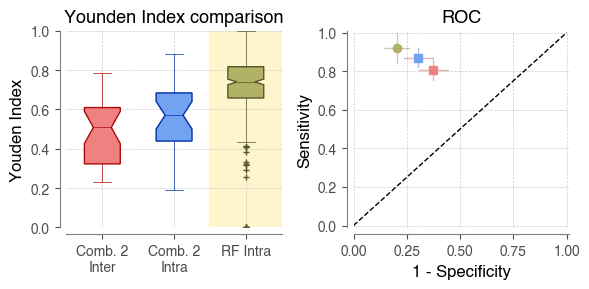

In [23]:
# Combine data from all limbs
lightc = ["#f08181", "#72a3f2", "#ffaf69", "#ababab", "#d2a679", "#b2b266"]
darkc = ["#a80a0a", "#002eab", "#bd6e00", "black", "#86592d", "#55552b"]
fig = plt.figure(figsize=(6, 3))
gs = gridspec.GridSpec(1, 2, height_ratios=[1], width_ratios=[3, 3])
ax = plt.subplot(gs[0, 0])

# GMAC Inter Subject Model
j = 0
_vals = np.hstack([curr_perf["youden"][i][1] for i in range(4)])
ax.boxplot(x=_vals, positions=[j],
        widths=0.5, notch=True, patch_artist=True,
        boxprops=dict(facecolor=lightc[j], color=darkc[j], alpha=1.0),
        capprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
        whiskerprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
        flierprops=dict(color=darkc[j], markeredgecolor=darkc[j],
                        markerfacecolor=darkc[j], marker='+', markersize=4),
        medianprops=dict(color=darkc[j], alpha=1.0, lw=0.5))

# GMAC Intra Subject Model
j = 1
ax.boxplot(x=gmac_intra_perf_df["youden"].values, positions=[j],
        widths=0.5, notch=True, patch_artist=True,
        boxprops=dict(facecolor=lightc[j], color=darkc[j], alpha=1.0),
        capprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
        whiskerprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
        flierprops=dict(color=darkc[j], markeredgecolor=darkc[j],
                        markerfacecolor=darkc[j], marker='+', markersize=4),
        medianprops=dict(color=darkc[j], alpha=1.0, lw=0.5))

# RF INTRA
j = 2
_vals = np.hstack([prev_perf_rfintra["youden"][i] for i in range(4)])
_vals = _vals[~np.isnan(_vals)]
ax.boxplot(x=_vals, positions=[j],
           widths=0.5, notch=True, patch_artist=True,
           boxprops=dict(facecolor=lightc[-1], color=darkc[-1], alpha=1.0),
           capprops=dict(color=darkc[-1], alpha=1.0, lw=0.5),
           whiskerprops=dict(color=darkc[-1], alpha=1.0, lw=0.5),
           flierprops=dict(color=darkc[-1], markeredgecolor=darkc[-1],
                           markerfacecolor=darkc[-1], marker='+', markersize=4),
           medianprops=dict(color=darkc[-1], alpha=1.0, lw=0.5))
# Backgrounds
background = plt.Rectangle((0.66, 0), 1, 1,
                           transform=ax.transAxes,
                           color='#fff5cc', zorder=-1)
ax.add_patch(background)

ax.set_ylim(0.0, 1.0)
ax.set_xlim(-0.5, 2.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
ax.grid(color='0.8', linestyle='--', linewidth=0.5);
ax.set_xticklabels(
    ["Comb. 2\nInter", "Comb. 2\nIntra", "RF Intra"],
)
ax.set_ylabel("Youden Index", fontsize=12)
ax.set_title("Younden Index comparison", fontsize=13)

# ROC plot
ax = plt.subplot(gs[0, 1])
ax.plot([0, 1], [0, 1], lw=1, color="black", ls="--")

# PC 1
_valsens = np.hstack([curr_perf["sensitivity"][i][0] for i in range(4)])
_valspec = np.hstack([curr_perf["specificity"][i][0] for i in range(4)])
_xmean, _ymean = np.mean(_valspec), np.mean(_valsens)
_xstd, _ystd = np.std(_valspec), np.std(_valsens)
ax.plot([1 - _xmean - 0.5 * _xstd, 1 - _xmean + 0.5 * _xstd],
        [_ymean, _ymean], color=darkc[0], alpha=0.3, lw=1)
ax.plot([1 - _xmean, 1 - _xmean],
        [_ymean - 0.5 * _ystd, _ymean + 0.5 * _ystd], color=darkc[0], alpha=0.3, lw=1)
ax.plot([1 - _xmean], [_ymean], marker="s", ms=6, color=lightc[0], alpha=1)

# PC 1 - Intra
_valsens = gmac_intra_perf_df["sensitivity"]
_valspec = gmac_intra_perf_df["specificity"]
_xmean, _ymean = np.mean(_valspec), np.mean(_valsens)
_xstd, _ystd = np.std(_valspec), np.std(_valsens)
ax.plot([1 - _xmean - 0.5 * _xstd, 1 - _xmean + 0.5 * _xstd],
        [_ymean, _ymean], color=darkc[0], alpha=0.3, lw=1)
ax.plot([1 - _xmean, 1 - _xmean],
        [_ymean - 0.5 * _ystd, _ymean + 0.5 * _ystd], color=darkc[1], alpha=0.3, lw=1)
ax.plot([1 - _xmean], [_ymean], marker="s", ms=6, color=lightc[1], alpha=1)

# RF Intra
_valsens = np.hstack([prev_perf_rfintra["sensitivity"][i] for i in range(4)])
_valspec = np.hstack([prev_perf_rfintra["specificity"][i] for i in range(4)])
_xmean, _ymean = np.nanmean(_valspec), np.nanmean(_valsens)
_xstd, _ystd = np.nanstd(_valspec), np.nanstd(_valsens)
ax.plot([1 - _xmean - 0.5 * _xstd, 1 - _xmean + 0.5 * _xstd],
        [_ymean, _ymean], color=darkc[5], alpha=0.3, lw=1)
ax.plot([1 - _xmean, 1 - _xmean],
        [_ymean - 0.5 * _ystd, _ymean + 0.5 * _ystd], color=darkc[5], alpha=0.3, lw=1)
ax.plot([1 - _xmean], [_ymean], marker="o", ms=6, color=lightc[5], alpha=1)

ax.set_ylim(-0.01, 1.01)
ax.set_xlim(0.0, 1.01)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
ax.grid(color='0.8', linestyle='--', linewidth=0.5);
ax.set_ylabel("Sensitivity", fontsize=12)
ax.set_xlabel("1 - Specificity", fontsize=12)
ax.set_title("ROC", fontsize=13)

plt.tight_layout()

fig.savefig(pathlib.Path(outdir, "gmac_intra_summary.pdf"), bbox_inches="tight")
fig.savefig(pathlib.Path(outdir, "gmac_intra_summary.svg"), bbox_inches="tight")

In [54]:
# Limbs
limbs = ["left", "right", "aff", "unaff"]
diff_perf = [[[], []],
             [[], []]]
for i, limb in enumerate(limbs):
    for subj in gmac_perf_df[limb]["subject"].unique():
        _inx = ((gmac_perf_df[limb]["am_th"] == 0.1) &
                (gmac_perf_df[limb]["am_th_band"] == 0) &
                (gmac_perf_df[limb]["p_th"] == 20) &
                (gmac_perf_df[limb]["p_th_band"] == 40) &
                (gmac_perf_df[limb]["subject"] == subj))
        _youden = gmac_perf_df[limb][_inx]["youden"].values[0]
        # RF intra
        diff_perf[0][1].append(_youden)

        # Best params
        _bpinx = (
            (best_params["limb"] == limb) &
            (best_params["subject"] == subj)
        )
        _inx = ((gmac_perf_df[limb]["am_th"] == best_params[_bpinx]["amth"].values[0]) &
                (gmac_perf_df[limb]["am_th_band"] == 0) &
                (gmac_perf_df[limb]["p_th"] == best_params[_bpinx]["pth"].values[0]) &
                (gmac_perf_df[limb]["p_th_band"] == best_params[_bpinx]["pthb"].values[0]) &
                (gmac_perf_df[limb]["subject"] == subj))
        _youden = gmac_perf_df[limb][_inx]["youden"].values[0]
        diff_perf[0][0].append(_youden)
        diff_perf[1][0].append(_youden)
        # RF intra
        diff_perf[1][1].append(
            subash22df[limb][(subash22df[limb].method == "RF intra") &
                             (subash22df[limb].subject == subj)]["youden"].mean()
        )

In [58]:
# Perform paired t-tests
p_values = []
for i in range(2):
    t_stat, p_val = stats.ttest_rel(diff_perf[i][0], diff_perf[i][1])
    p_values.append((i, t_stat, p_val))

# Apply a multiple comparisons correction method (e.g., Bonferroni)
alpha = 0.05
adjusted_alpha = alpha / len(p_values)

for i, t_stat, p_val in p_values:
    if p_val < adjusted_alpha:
        print(f"Pairwise comparison for combination {i + 1} is statistically significant.")

Pairwise comparison for combination 1 is statistically significant.
Pairwise comparison for combination 2 is statistically significant.
